# Evaluating and Retraining VGG-19 Model:
---

## Outline of tasks performed in this notebook:
* Load the phase-1 model (vgg19)
* Test performance on pggan and stargan generated images
* Retrain the model with 140k+pggan+stargan data (if needed)
* Test the performance on pggan_all and stargan_all (Expected to perform better)


## Imports, Settings and Globals:

In [1]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from pylab import *
from keras.callbacks import LearningRateScheduler
from keras import models
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
from keras.applications.vgg19 import VGG19
import itertools
from sklearn.metrics import confusion_matrix
from keras import optimizers
from PIL import Image
import pandas as pd
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10):
        def schedule(epoch):
            return initial_lr * (decay_factor ** np.floor(epoch / step_size))
        return LearningRateScheduler(schedule)

In [3]:
lr_sched = step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=2)


### Load trained model from Phase-1

In [4]:
import tensorflow as tf
new_model = tf.keras.models.load_model('/kaggle/working/vgg19.h5')

In [5]:
# Print model summary 
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 26,513,217
Trainable params: 6,488,833
Non-trainable params: 20,024,384
_________________________________________________________________


### Evaluate model's performance on PGGAN generated fake images data:

In [6]:
# Load pggan images to test the performance:
test_datagen_pggan = ImageDataGenerator()
TEST_DIR_pggan = '/kaggle/input/pggan-all/pggan_v1_v2/test'
test_generator_pggan = test_datagen_pggan.flow_from_directory(TEST_DIR_pggan,target_size=(224,224),batch_size=32,class_mode='binary', shuffle=False )

Found 7907 images belonging to 2 classes.


In [7]:
# Check Test loss and accuracy:
score = new_model.evaluate(test_generator_pggan)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

248/248 [==============================] - 98s 342ms/step - loss: 2.8725 - accuracy: 0.5028
Test loss: 2.8724732398986816
Test accuracy: 0.5028455853462219


In [8]:
# Check prediction probabilities: 
THRESHOLD = 0.5
test_predict_probability_pggan = new_model.predict(test_generator_pggan)
test_predict_pggan = np.where(test_predict_probability_pggan > THRESHOLD, 1, 0)

test_predict_pggan

248/248 [==============================] - 52s 208ms/step


array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

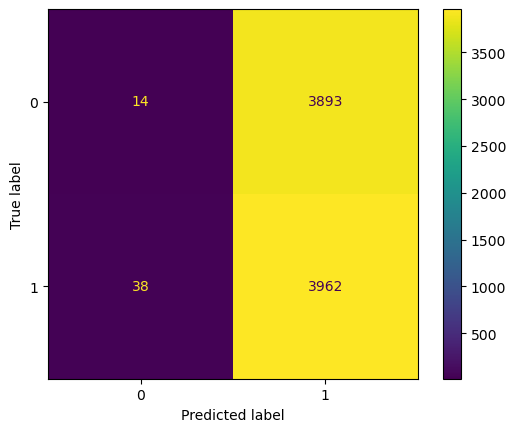

In [9]:
# Plotting confusion matrix to better understand teh results
cm = confusion_matrix(test_generator_pggan.classes, test_predict_pggan, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])
disp.plot()
plt.show()

### Result:
#### As expected, the model did not perform well on PGGAN generated fake images.

### Evaluate model's performance on STARGAN generated fake images data:

In [10]:
# Load stargan images to test the performance:
test_datagen_stargan = ImageDataGenerator()
TEST_DIR_stargan = '/kaggle/input/stargan-test/stargan_test'
test_generator_stargan = test_datagen_stargan.flow_from_directory(TEST_DIR_stargan,target_size=(224,224),batch_size=32,class_mode='binary', shuffle=False )

Found 8000 images belonging to 2 classes.


In [11]:
# Check Test loss and accuracy:
score = new_model.evaluate(test_generator_stargan)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

250/250 [==============================] - 65s 259ms/step - loss: 2.7914 - accuracy: 0.4975
Test loss: 2.7913663387298584
Test accuracy: 0.4975000023841858


In [12]:
# Check prediction probabilities: 
THRESHOLD = 0.5
test_predict_probability_stargan = new_model.predict(test_generator_stargan)
test_predict_stargan = np.where(test_predict_probability_stargan > THRESHOLD, 1, 0)

test_predict_stargan

250/250 [==============================] - 50s 201ms/step


array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

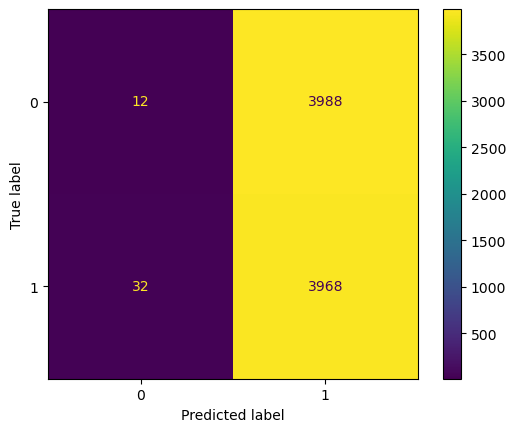

In [13]:
# Plotting confusion matrix to better understand teh results
cm = confusion_matrix(test_generator_stargan.classes, test_predict_stargan, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])
disp.plot()
plt.show()

### Result:
#### As expected, the model did not perform well on STARGAN generated fake images.

### Conclusion:
#### From the above results, we can infer that the model did not perform well in detecting the fake images generated by different GANs. Hence, we need to retrain the model to learn from the such diverse data which contains images generated by PGGAN and STARGAN.

#### Loading all-gan-data dataset which contains original 140k_real_and_fake_faces along with additional PGGAN and STARGAN generated images for retraining the model:
* STYLEGAN = 100k
* PGGAN = 40k
* STARGAN = 20k

In [7]:
# Load train dataset
TRAINING_DIR = '/kaggle/input/all-gan-data/all_data/real-vs-fake/train'
train_datagen = ImageDataGenerator(
      # rescale=1./255
      # ,rotation_range=40,
      # width_shift_range=0.2,
      # height_shift_range=0.2,
      # shear_range=0.2,
      # zoom_range=0.2,
      # horizontal_flip=True,
      # fill_mode='nearest'
)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,target_size=(224,224),batch_size=32,class_mode='binary')

# Load validation dataset
VALIDATION_DIR = '/kaggle/input/all-gan-data/all_data/real-vs-fake/valid'
validation_datagen = ImageDataGenerator()
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,target_size=(224,224),batch_size=32,class_mode='binary');

Found 159957 images belonging to 2 classes.
Found 25998 images belonging to 2 classes.


In [8]:
# Load test dataset
test_datagen = ImageDataGenerator()
TEST_DIR = '/kaggle/input/all-gan-data/all_data/real-vs-fake/test'
test_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=(224,224),batch_size=32,class_mode='binary', shuffle=False )

Found 75992 images belonging to 2 classes.


### Retraining the model on more diverse dataset:

In [10]:
history = new_model.fit(
      train_generator,
      steps_per_epoch=500,  # 2000 images = batch_size * steps
      epochs=30,
      validation_data=validation_generator,
      validation_steps=10,
      callbacks=[lr_sched]
)

Epoch 1/30
500/500 [==============================] - 184s 367ms/step - loss: 0.1981 - accuracy: 0.9201 - val_loss: 0.3371 - val_accuracy: 0.8656 - lr: 0.0010
Epoch 2/30
500/500 [==============================] - 171s 342ms/step - loss: 0.1907 - accuracy: 0.9247 - val_loss: 0.3685 - val_accuracy: 0.8719 - lr: 0.0010
Epoch 3/30
500/500 [==============================] - 158s 316ms/step - loss: 0.1619 - accuracy: 0.9370 - val_loss: 0.2223 - val_accuracy: 0.9031 - lr: 7.5000e-04
Epoch 4/30
500/500 [==============================] - 153s 305ms/step - loss: 0.1622 - accuracy: 0.9346 - val_loss: 0.3415 - val_accuracy: 0.8938 - lr: 7.5000e-04
Epoch 5/30
500/500 [==============================] - 149s 297ms/step - loss: 0.1571 - accuracy: 0.9383 - val_loss: 0.3247 - val_accuracy: 0.8938 - lr: 5.6250e-04
Epoch 6/30
500/500 [==============================] - 145s 290ms/step - loss: 0.1459 - accuracy: 0.9411 - val_loss: 0.1769 - val_accuracy: 0.9344 - lr: 5.6250e-04
Epoch 7/30
500/500 [==========

In [11]:
# Save the retrained model
new_model.save('vgg19_retrained.h5')

### Evaluate model's performance on a diverse test dataset of fake images:

In [10]:
# Check Test loss and accuracy:
score = new_model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2375/2375 [==============================] - 657s 277ms/step - loss: 0.0777 - accuracy: 0.9723
Test loss: 0.07771610468626022
Test accuracy: 0.9723392128944397


In [11]:
# Check prediction probabilities:
THRESHOLD = 0.5
test_predict_probability = new_model.predict(test_generator)
test_predict = np.where(test_predict_probability > THRESHOLD, 1, 0)

test_predict

2375/2375 [==============================] - 538s 227ms/step


array([[0],
       [0],
       [0],
       ...,
       [0],
       [1],
       [1]])

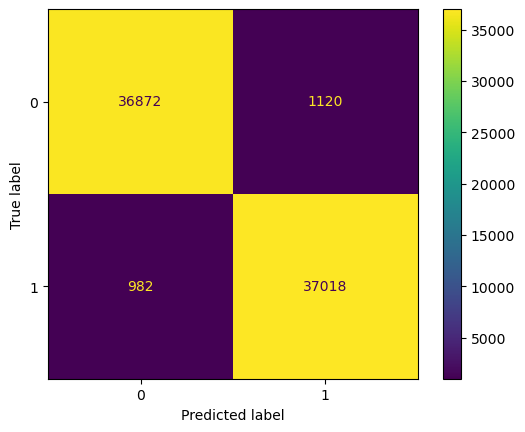

In [12]:
# Plot confusion matrix to better understand the results
cm = confusion_matrix(test_generator.classes, test_predict, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])
disp.plot()
plt.show()

### Evaluate retrained model's performance on PGGAN generated fake images data:

In [16]:
# Check pggan test performance:
test_datagen_pggan = ImageDataGenerator()
TEST_DIR_pggan = '/kaggle/input/pggan-all/pggan_v1_v2/test'
test_generator_pggan = test_datagen_pggan.flow_from_directory(TEST_DIR_pggan,target_size=(224,224),batch_size=32,class_mode='binary', shuffle=False )

Found 7907 images belonging to 2 classes.


In [17]:
# Check Test loss and accuracy:
score = new_model.evaluate(test_generator_pggan)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

248/248 [==============================] - 97s 392ms/step - loss: 0.0037 - accuracy: 0.9990
Test loss: 0.0037190571893006563
Test accuracy: 0.9989882111549377


In [18]:
# Check prediction probabilities:
THRESHOLD = 0.5
test_predict_probability_pggan = new_model.predict(test_generator_pggan)
test_predict_pggan = np.where(test_predict_probability_pggan > THRESHOLD, 1, 0)

test_predict_pggan

248/248 [==============================] - 51s 204ms/step


array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

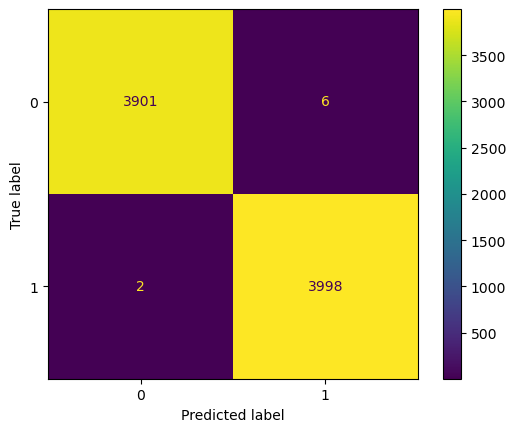

In [19]:
# Plot confusion matrix to better understand the results
cm = confusion_matrix(test_generator_pggan.classes, test_predict_pggan, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])
disp.plot()
plt.show()

### Conclusion:
#### The retrained model performed well on the PGGAN generated fake images dataset.

In [9]:
import tensorflow as tf
new_model = tf.keras.models.load_model('/kaggle/working/vgg19_retrained.h5')
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 26,513,217
Trainable params: 6,488,833
Non-trainable params: 20,024,384
_________________________________________________________________


### Evaluate retrained model's performance on STARGAN generated fake images data:

In [8]:
# Check stargan test performance:
test_datagen_stargan = ImageDataGenerator()
TEST_DIR_stargan = '/kaggle/input/stargan-test/stargan_test'
test_generator_stargan = test_datagen_stargan.flow_from_directory(TEST_DIR_stargan,target_size=(224,224),batch_size=32,class_mode='binary', shuffle=False )

Found 8000 images belonging to 2 classes.


In [10]:
# Check Test loss and accuracy:
score = new_model.evaluate(test_generator_stargan)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

250/250 [==============================] - 65s 223ms/step - loss: 0.0016 - accuracy: 0.9998
Test loss: 0.0016109902644529939
Test accuracy: 0.999750018119812


In [11]:
# Check prediction probabilities:
THRESHOLD = 0.5
test_predict_probability_stargan = new_model.predict(test_generator_stargan)
test_predict_stargan = np.where(test_predict_probability_stargan > THRESHOLD, 1, 0)

test_predict_stargan

250/250 [==============================] - 49s 197ms/step


array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

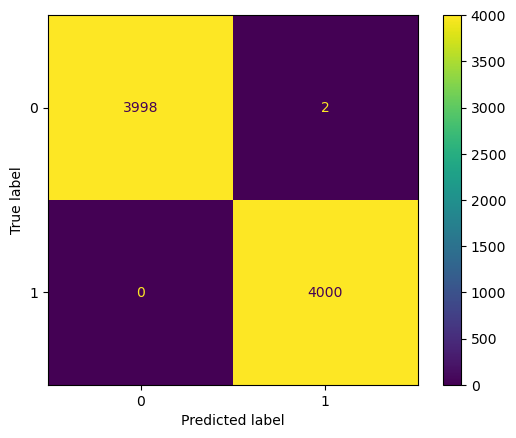

In [12]:
# Plot confusion matrix to better understand the results
cm = confusion_matrix(test_generator_stargan.classes, test_predict_stargan, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])
disp.plot()
plt.show()

### Conclusion:
#### The retrained model performed well on the STARGAN generated fake images dataset.